#다시 시작

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchsummaryX

In [ ]:
!pip install pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=68e31f81a9fb72ebd9856df47841448a2672813377bea59276be172c01651bd4
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.0 MB/s eta 0:00:00


In [ ]:
import os
import random
import pywt
import cv2

# External Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from skimage import io, transform
import sklearn.model_selection as sk

# PyTorch
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim import lr_scheduler
from torchvision import utils
from torchsummary import summary
from torchsummaryX import summary

import pretrainedmodels
import timm
from google.colab.patches import cv2_imshow


In [ ]:
df_csv = '/content/drive/MyDrive/brainAI (1)/data/train_set/train.csv'
df = pd.read_csv(df_csv)
df

,Index,Aneurysm,L_ICA,R_ICA,L_PCOM,R_PCOM,L_AntChor,R_AntChor,L_ACA,R_ACA,...,R_MCA,L_VA,R_VA,L_PICA,R_PICA,L_SCA,R_SCA,BA,L_PCA,R_PCA
0,1001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1002,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1004,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1005,1,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
4,1006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,2607,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1123,2608,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1124,2609,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1125,2610,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_path = '/content/drive/MyDrive/brainAI (1)/data/new24_!'

In [ ]:
IMG_SIZE = 256

data = []
# classes = ['yes', 'no']

files = os.listdir(train_path)
for f in files:
  img = Image.open(train_path + '/' + f)
  # 이미지 리사이즈
  img = img.resize((IMG_SIZE, IMG_SIZE))
  # PIL 이미지를 numpy 배열로 변환
  img_np = np.array(img)
  # 노이즈 제거
  median_filtered_image = cv2.medianBlur(img_np, 3)
  one_img = np.asarray(np.float32(median_filtered_image))
  norm_img = one_img / 255.0

  img = np.asarray([norm_img])
  data.append(img)

# label = torch.from_numpy(labels)
# labels = labels.reshape(-1, 21)

In [ ]:
data = np.array(data, dtype='float32')
image = torch.from_numpy(data)
image = image.view(-1, 3, 256, 256)

df.iloc[:, 2:].values
label = np.array(df, dtype='int64')
label_multi = torch.from_numpy(label)

In [ ]:
label_multi

tensor([[1001,    0,    0,  ...,    0,    0,    0],
        [1002,    1,    0,  ...,    0,    0,    0],
        [1004,    1,    0,  ...,    0,    0,    0],
        ...,
        [2609,    0,    0,  ...,    0,    0,    0],
        [2610,    0,    0,  ...,    0,    0,    0],
        [2611,    0,    0,  ...,    0,    0,    0]])

In [ ]:
# 데이터셋 정의
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        images = self.data[idx]
        labels = self.labels[idx]  # 인덱스 범위를 벗어나지 않도록 수정
        return images, labels

In [ ]:
dataset = CustomDataset(image,label_multi)

In [ ]:
dataset[0]

(tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.7608, 0.7608, 0.7647],
          [0.7647, 0.7647, 0.7647,  ..., 0.7529, 0.7647, 0.7647],
          [0.7647, 0.7725, 0.7725,  ..., 0.7686, 0.7686, 0.7686],
          ...,
          [0.7098, 0.7098, 0.7020,  ..., 0.6980, 0.6824, 0.6824],
          [0.6824, 0.6824, 0.6824,  ..., 0.7765, 0.7765, 0.7765],
          [0.6941, 0.6941, 0.6941,  ..., 0.7373, 0.7373, 0.7333]],
 
         [[0.7333, 0.7333, 0.7176,  ..., 0.6627, 0.6824, 0.6824],
          [0.6824, 0.6863, 0.6863,  ..., 0.7765, 0.7765, 0.7765],
          [0.6784, 0.6784, 0.6784,  ..., 0.7373, 0.7373, 0.7373],
          ...,
          [0.7529, 0.7569, 0.7569,  ..., 0.7686, 0.7686, 0.7686],
          [0.7686, 0.7686, 0.7686,  ..., 0.7490, 0.7490, 0.7529],
          [0.7529, 0.7529, 0.7569,  ..., 0.6627, 0.6941, 0.6941]],
 
         [[0.6941, 0.7451, 0.7451,  ..., 0.7686, 0.7686, 0.7686],
          [0.7686, 0.7686, 0.7686,  ..., 0.7529, 0.7529, 0.7608],
          [0.7608, 0.7608, 0.7608,  ...,

In [ ]:
val_percent = int(0.2 * len(dataset)) #setting 15 percent of the total number of images for validation
train_size = len(dataset) - val_percent
val_size = len(dataset) - train_size
train_size, val_size

(902, 225)

In [ ]:
from torch.utils.data import random_split

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size]) #splitting the dataset for training and validation.
len(train_ds), len(val_ds)

(902, 225)

In [ ]:
batch_size = 1
train_loader = DataLoader(train_ds, 16, shuffle=True)
val_loader = DataLoader(val_ds, 8, shuffle=False)

In [ ]:
from torchvision.models import resnet50

In [ ]:
from torchsummary import summary

In [ ]:
class MnistModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = resnet50(pretrained=True)
        self.classifier = nn.Linear(1000, 23)

    def forward(self, x):
        x = self.resnet(x)
        # x = self.classifier(x)
        x = torch.sigmoid(self.classifier(x))

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MnistModel().to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 304MB/s]


In [ ]:
print(summary(model, input_size=(3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
import torch

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Training
def run_train(model):
    model.train()
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    total_loss = 0
    correct = 0
    incorrect = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        predictions = outputs > 0.5
        correct += (predictions == labels).sum().item()
        incorrect += (predictions != labels).sum().item()

    accuracy = correct / (correct + incorrect)
    average_loss = total_loss / len(train_loader)

    return accuracy, average_loss, predictions, labels

# Validation
def run_valid(model):
    model.eval()
    criterion = nn.MultiLabelSoftMarginLoss()

    total_loss = 0
    correct = 0
    incorrect = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions = outputs > 0.5
            correct += (predictions == labels).sum().item()
            incorrect += (predictions != labels).sum().item()

    accuracy = correct / (correct + incorrect)
    average_loss = total_loss / len(val_loader)

    return accuracy, average_loss, predictions, labels


***START EPOCH***
# Epoch: 0 / 100
Train Accuracy: 0.5375494071146245
Validation Accuracy: 0.6088888888888889


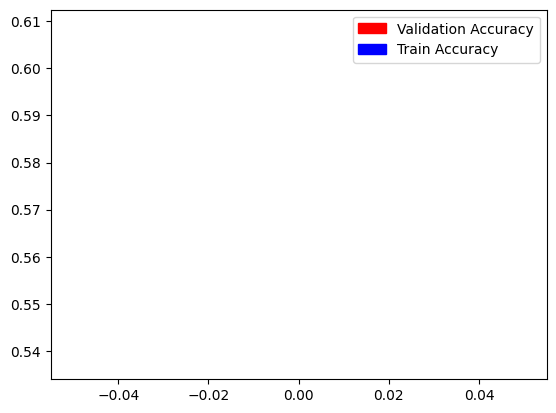

# Epoch: 1 / 100
Train Accuracy: 0.628217487708474
Validation Accuracy: 0.6664734299516908
# Epoch: 2 / 100
Train Accuracy: 0.7093415598187602
Validation Accuracy: 0.7383574879227053
# Epoch: 3 / 100
Train Accuracy: 0.7753301841318808
Validation Accuracy: 0.7988405797101449
# Epoch: 4 / 100
Train Accuracy: 0.8249301070085799
Validation Accuracy: 0.8465700483091787
# Epoch: 5 / 100
Train Accuracy: 0.8594427841511617
Validation Accuracy: 0.8755555555555555


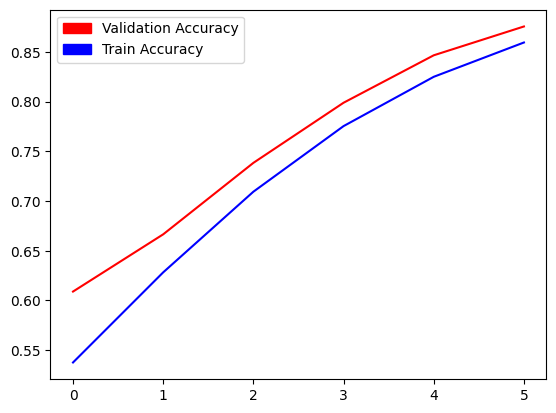

# Epoch: 6 / 100
Train Accuracy: 0.880651691892413
Validation Accuracy: 0.8890821256038647
# Epoch: 7 / 100
Train Accuracy: 0.895835341752627
Validation Accuracy: 0.8997101449275362
# Epoch: 8 / 100
Train Accuracy: 0.9011375686879398
Validation Accuracy: 0.904927536231884
# Epoch: 9 / 100
Train Accuracy: 0.9046563192904656
Validation Accuracy: 0.9091787439613527
# Epoch: 10 / 100
Train Accuracy: 0.9062951894341078
Validation Accuracy: 0.9097584541062802


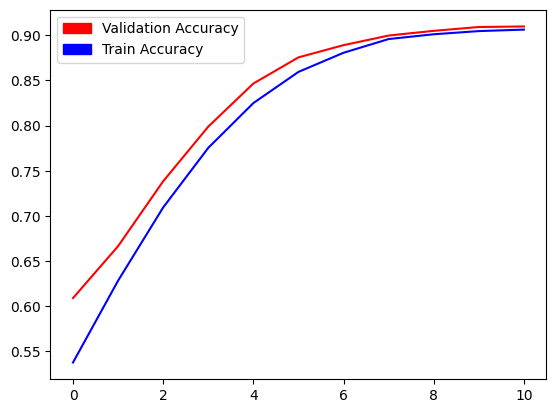

# Epoch: 11 / 100
Train Accuracy: 0.9085124843343295
Validation Accuracy: 0.9116908212560386
# Epoch: 12 / 100
Train Accuracy: 0.9091391111539574
Validation Accuracy: 0.9130434782608695
# Epoch: 13 / 100
Train Accuracy: 0.9096211317844404
Validation Accuracy: 0.9130434782608695
# Epoch: 14 / 100
Train Accuracy: 0.9100549503518751
Validation Accuracy: 0.9130434782608695
# Epoch: 15 / 100
Train Accuracy: 0.9102959606671166
Validation Accuracy: 0.9126570048309178


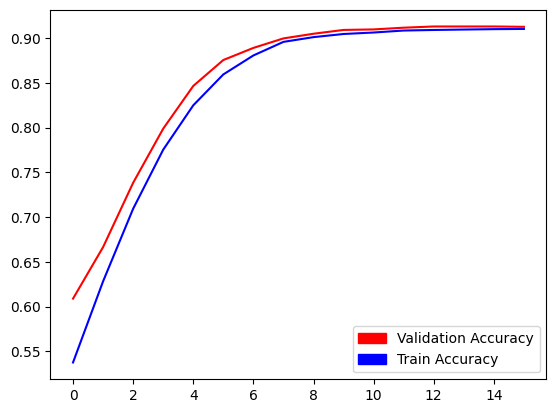

# Epoch: 16 / 100
Train Accuracy: 0.9099103441627302
Validation Accuracy: 0.9132367149758455
# Epoch: 17 / 100
Train Accuracy: 0.9102959606671166
Validation Accuracy: 0.9134299516908213
# Epoch: 18 / 100
Train Accuracy: 0.909572929721392
Validation Accuracy: 0.9132367149758455
# Epoch: 19 / 100
Train Accuracy: 0.9105369709823581
Validation Accuracy: 0.9134299516908213
# Epoch: 20 / 100
Train Accuracy: 0.9102959606671166
Validation Accuracy: 0.9136231884057971


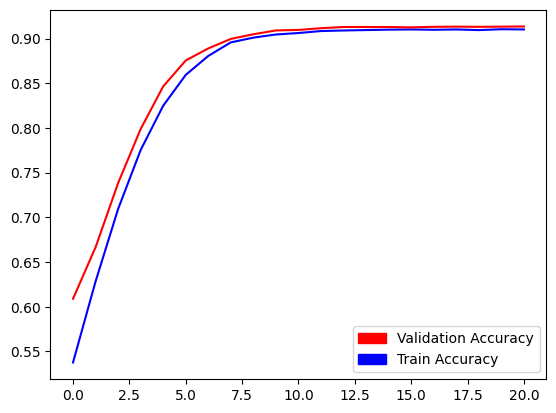

# Epoch: 21 / 100
Train Accuracy: 0.9098621420996819
Validation Accuracy: 0.9132367149758455
# Epoch: 22 / 100
Train Accuracy: 0.9099585462257784
Validation Accuracy: 0.9134299516908213
# Epoch: 23 / 100
Train Accuracy: 0.9097657379735853
Validation Accuracy: 0.9132367149758455
# Epoch: 24 / 100
Train Accuracy: 0.9101031524149233
Validation Accuracy: 0.9134299516908213
# Epoch: 25 / 100
Train Accuracy: 0.9099585462257784
Validation Accuracy: 0.9130434782608695


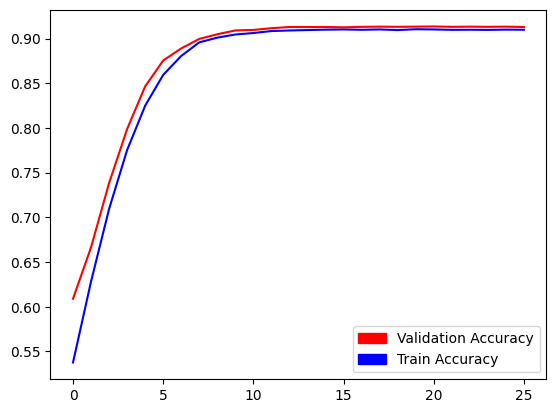

# Epoch: 26 / 100
Train Accuracy: 0.9099103441627302
Validation Accuracy: 0.9130434782608695
# Epoch: 27 / 100
Train Accuracy: 0.9099585462257784
Validation Accuracy: 0.9130434782608695
# Epoch: 28 / 100
Train Accuracy: 0.9094765255952955
Validation Accuracy: 0.9132367149758455
# Epoch: 29 / 100
Train Accuracy: 0.9096211317844404
Validation Accuracy: 0.9130434782608695
Best Validation Accuracy: 0.9136231884057971 achieved at epoch 20


In [ ]:
best_accuracy = 0
best_epoch = 0

# Learning
acc_t = []
acc_v = []
prediction_v = []
label_v = []

epoch = 30
# patience = 10  # Number of epochs to wait for improvement
counter = 0  # Counter for early stopping

print('***START EPOCH***')

for E in range(epoch):
    print('# Epoch: {} / 100'.format(E))
    accuracy_t, loss_t, pred_t, truth_t = run_train(model)
    accuracy_v, loss_v, pred_v, truth_v = run_valid(model)
    prediction_v.append(pred_v)
    label_v.append(truth_v)

    print('Train Accuracy: {}'.format(accuracy_t))
    print('Validation Accuracy: {}'.format(accuracy_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)

    if accuracy_v > best_accuracy:
        best_accuracy = accuracy_v
        best_epoch = E
        # Save the model
        torch.save(model, 'best_model.pth')
        counter = 0
    else:
        counter += 1

    # if counter >= patience:
    #     print('Early stopping. No improvement in validation accuracy for {} epochs.'.format(patience))
    #     break

    if E % 5 == 0:
        plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
        blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
        red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()

print('Best Validation Accuracy: {} achieved at epoch {}'.format(best_accuracy, best_epoch))


In [ ]:
torch.save(model,'/content/drive/MyDrive/multi_best_model1')